> ## ARIMA model

In this section, we will use ARIMA model to predict rental prices for 1, 2 and 3-bedroom flats, 2, 3 and 4-bedroom houses and for all properties in the next 3 years.

> ### Import libraries and functions

In [153]:
%run ../scripts/'arima model.py'
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from pmdarima import auto_arima

> ### Check All properties

We will check and visualise the rental prices in one suburb of the all properties' data.

In [136]:
# Read the cleaned historical data from ..data/curated
all_properties = pd.read_csv('../data/curated/historical without postcode/cleaned All properties.csv')

all_properties

,suburb,Mar 2000,Jun 2000,Sep 2000,Dec 2000,Mar 2001,Jun 2001,Sep 2001,Dec 2001,Mar 2002,...,Dec 2020,Mar 2021,Jun 2021,Sep 2021,Dec 2021,Mar 2022,Jun 2022,Sep 2022,Dec 2022,Mar 2023
0,Albert Park-Middle Park-West St Kilda,260,260,270,275,275,280,280,290,300,...,550,500,500,500,495,500,515,500,525,545
1,Armadale,200,200,205,210,215,220,225,230,233,...,495,450,440,425,420,430,450,450,460,490
2,Carlton North,260,260,265,270,270,275,280,280,290,...,590,580,575,575,580,580,595,600,600,620
3,Carlton-Parkville,260,260,260,260,260,260,265,270,270,...,395,350,340,330,320,310,319,340,350,400
4,CBD-St Kilda Rd,320,320,320,320,320,320,320,320,320,...,420,380,369,350,350,365,390,419,450,500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,Dandenong North-Endeavour Hills,160,160,160,160,165,165,170,170,170,...,360,360,360,365,370,375,380,390,391,400
101,Narre Warren-Hampton Park,165,165,170,170,170,175,175,175,180,...,380,385,390,395,400,405,410,420,430,440
102,Noble Park,140,140,140,145,145,145,145,145,150,...,360,360,355,360,360,360,370,375,380,385
103,Pakenham,155,155,160,160,160,165,165,165,165,...,360,360,365,370,375,380,390,400,410,420


> ### Visualisation of First suburb

We will visualise the rental price of one suburb in the all properties' data to get an intuition of the trend and parameters for the ARIMA model.

In [138]:
all_properties = prepare_for_arima(all_properties, 'suburb')

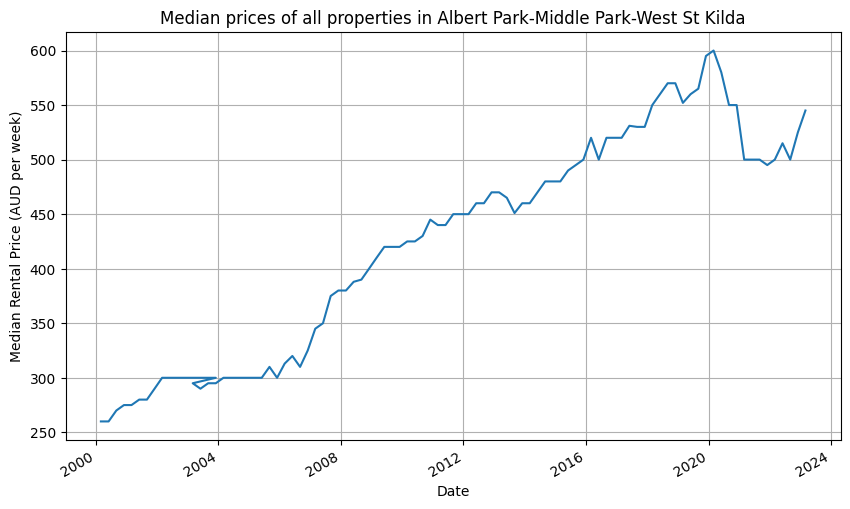

In [139]:
# Extract data for the first suburb
first_suburb = all_properties.index[0]
rental_prices = all_properties.loc[first_suburb]

# Plot the time series
plt.figure(figsize=(10, 6))
rental_prices.plot()
plt.title(f'Median prices of all properties in {first_suburb}')
plt.xlabel('Date')
plt.ylabel('Median Rental Price (AUD per week)')
plt.grid(True)
plt.show()

We can see that there is an upward trend in median rental prices over time, suggesting that this is a non-stationary time series. We will perform ADF statistical test to test if the time series for the first suburb is stationary.

ADF (Augmented Dickey Fuller) Test:
- Null Hypothesis: The series is non-stationary
- Alternate Hypothesis: The series is stationary

In [74]:
# Perform ADF test for the first suburb
adf_test = adfuller(rental_prices)

print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
for key, value in adf_test[4].items():
    print(f'Critical Values {key}: {value}')


ADF Statistic: -0.9570277449899074
p-value: 0.7686131666477682
Critical Values 1%: -3.510711795769895
Critical Values 5%: -2.8966159448223734
Critical Values 10%: -2.5854823866213152


We can see that the p-value is high and since this is a left-tailed test, the ADF statistic is higher than critical values of all levels of significance, suggesting that we failed to reject the null hypothesis that the series is non-stationary.

Since the first suburb's rental prices is a non-stationary series, we will set d > 0 and below is an attempt to find d.

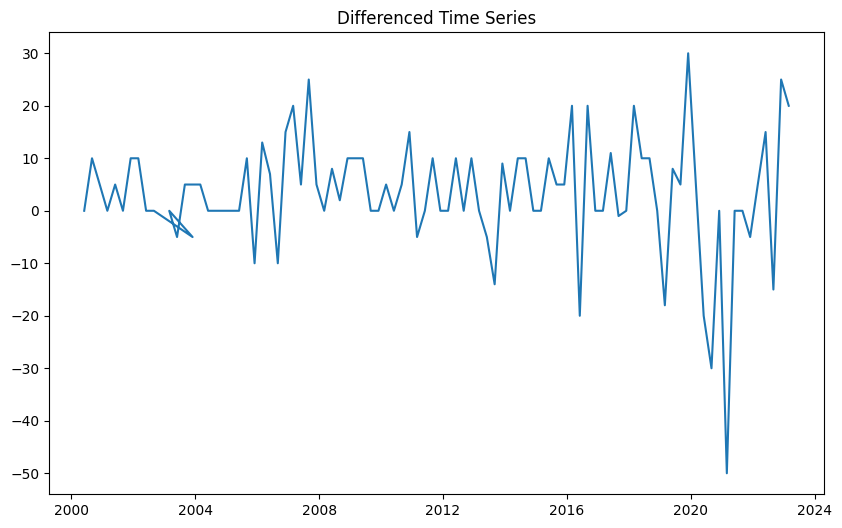

ADF Statistic (Differenced): -4.016246621768229
p-value (Differenced): 0.0013277881460712424


In [75]:
# Find d of the first suburb

# First-order differencing (d=1)
data_diff = rental_prices.diff().dropna()

# Plot differenced data
plt.figure(figsize=(10, 6))
plt.plot(data_diff)
plt.title("Differenced Time Series")
plt.show()

# Reapply ADF test to check if the differenced series is now stationary
adf_test_diff = adfuller(data_diff)

print(f'ADF Statistic (Differenced): {adf_test_diff[0]}')
print(f'p-value (Differenced): {adf_test_diff[1]}')

We can see that after the first-order differencing, the differences now flunctuate around zero, except for the data near 2019-2020, which is heavily impacted due to COVID. However in general from the ADF test, the p-value is significantly reduced and we can reject the null hypothesis that the series is non-stationary.

For now, we can see that d for this series is 1. We will compare this with the gridsearch result later.

We can find p by looking at the Partial Autocorrelation plot after differencing the data.

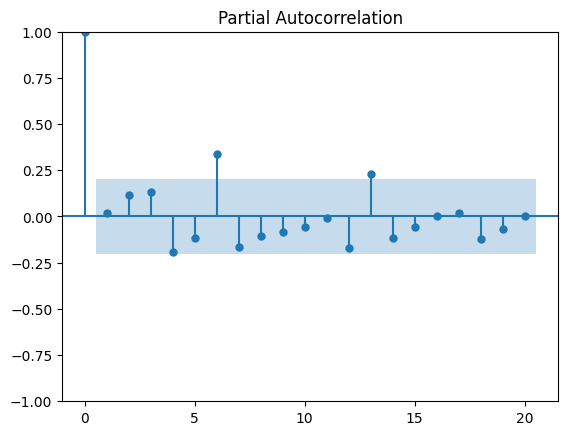

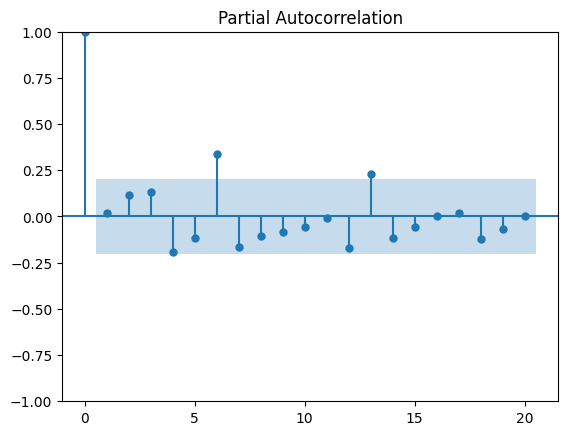

In [85]:
# Find p by plotting Partial Autocorrelation
plot_pacf(data_diff)

We can see that from the first lag the data is already in the blue region, so we can set p = 0.

We can find q by looking at the Autocorrelation plot.

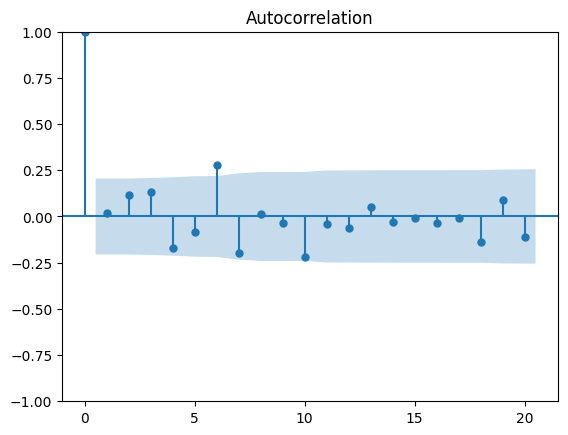

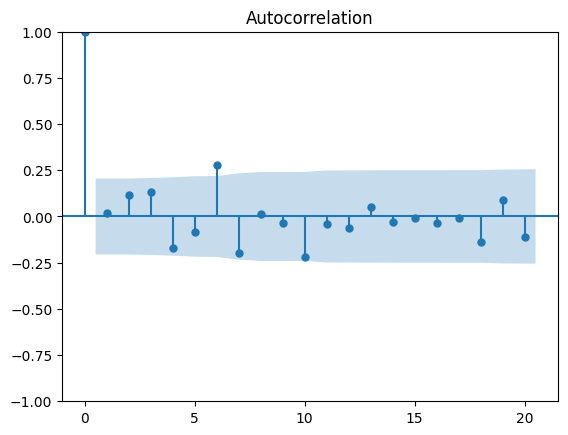

In [87]:
# Find q by looking at Autocorrelation plot
plot_acf(data_diff)

We can see that none of the lags are significantly out of limit, so we can set q = 0.

From inspection, we conclude that for the first suburb of the all properties' data, the parameters for ARIMA model are p = 0, d = 1, q = 0. We will check this against the auto grid search results below.

In [42]:
# Perform grid search for parameters of the first suburb
model = pm.auto_arima(
    rental_prices,              
    start_p=0, start_q=0, 
    max_p=5, max_q=5,       # Define the range for p and q to search
    d=None,                 
    seasonal=False,         
    trace=True,             
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True           
)

# Summary of the best model found
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=703.252, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=705.227, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=705.232, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=708.009, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=706.743, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.252 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   92
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -349.626
Date:                Sat, 28 Sep 2024   AIC                            703.252
Time:                        23:01:16   BIC                            708.274
Sample:                             0   HQIC                           705.278
                                 - 92                                         
Co

From the above result, the best ARIMA model found is (0,1,0) corresponding to p = 0, d = 1, q = 0. This aligns with our visualisation above.

We will use this grid search method to find the parameters for the ARIMA model for each suburb.

> ### 3-year predictions by suburb

In [154]:
# Read the dataframes and make a list
folder_path = '../data/curated/historical without postcode/'
file_names = ['cleaned 1 bedroom flat.csv', 'cleaned 2 bedroom flat.csv', 'cleaned 3 bedroom flat.csv',
              'cleaned 2 bedroom house.csv', 'cleaned 3 bedroom house.csv', 'cleaned 4 bedroom house.csv',
              'cleaned All properties.csv']

dataframe_list = read_make_list(folder_path, file_names)

We will predict median rental prices by suburb of each type of property: 1, 2, 3-bedroom flats, 2, 3, 4-bedroom houses and all properties in the next 3 years (until the end of 2027).

In [155]:
# Prepare the dataframe to be in the right format for ARIMA model
for i in range(len(dataframe_list)):
    dataframe_list[i] = prepare_for_arima(dataframe_list[i], 'suburb')

In [161]:
# Prepare filenames to be saved as
predict_filename = ['predict 1 bedroom flat.csv', 'predict 2 bedroom flat.csv', 'predict 3 bedroom flat.csv',
                    'predict 2 bedroom house.csv', 'predict 3 bedroom house.csv', 'predict 4 bedroom house.csv',
                    'predict all properties.csv']

# Prepare folder to store the predictions
folder_path = '../data/analysis/future prices by suburb'

growth_rates = predict_rental_prices(dataframe_list, 'suburb', folder_path, predict_filename)

> ### 3-year predictions by postcode

For visualisation purpose, we will run ARIMA model for historical with postcode, this will include less suburbs because not all postcodes are found.

In [162]:
folder_path = '../data/curated/historical with postcode/'
dataframe_list = read_make_list(folder_path, file_names)

# Prepare the dataframe to be in the right format for ARIMA model
for i in range(len(dataframe_list)):
    dataframe_list[i] = prepare_for_arima(dataframe_list[i], 'postcode')

# Prepare folder to store the predictions
folder_path = '../data/analysis/future prices by postcode'

predict_rental_prices(dataframe_list, 'postcode', folder_path, predict_filename)

/home/lqp303203/GitHub/MAST30034_Python/project-2-group-real-estate-industry-project-27/scripts/arima model.py:82: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  predict_dates = pd.date_range(start=dataframe_list[i].columns[-1], periods=20, freq='Q')
/home/lqp303203/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/lqp303203/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/lqp303203/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given w

> ### Predicted growth rates

From the calculated growth rates of each suburb for each property type above, we can see which 10 suburbs have the highest predicted growth rate.

In [159]:
property_types = ['one bed flat', 'two bed flat', 'three bed flat', 'two bed house', 'three bed house',
                 'four bed house', 'all properties']
for i in range(len(growth_rates)):
    top_10 = growth_rates[i].sort_values(ascending=False).head(10)
    property_type = property_types[i]
    print(f"Top 10 suburbs with highest predicted growth rate for {property_type}")
    print(top_10)

Top 10 suburbs with highest predicted growth rate for one bed flat
North Melbourne-West Melbourne    0.489410
South Yarra                       0.326692
Carlton North                     0.222432
South Melbourne                   0.217999
Coburg-Pascoe Vale South          0.216572
Caulfield                         0.202615
East St Kilda                     0.187325
Prahran-Windsor                   0.181441
Preston                           0.178935
Elwood                            0.177965
dtype: float64
Top 10 suburbs with highest predicted growth rate for two bed flat
North Melbourne-West Melbourne    0.318787
Caulfield                         0.247362
Carlton-Parkville                 0.234752
Berwick                           0.228370
Oak Park-Glenroy-Fawkner          0.227526
Collingwood-Abbotsford            0.221257
Richmond-Burnley                  0.206394
East St Kilda                     0.201589
Brunswick                         0.200216
East Brunswick                    